In [38]:
import anndata
import umap
import xgboost
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import pickle
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import mlflow
import re
regex = re.compile(r"perturbation_experiment_([^_]+)_level")


# genes = ["CTNNB1", "JUND", "CD320", "IFI6","RAC1"]

levels = ["0", "0.5", "1.0"]
data_dir = "/data/gene_perturbation_colon_epithelial_scGPT_with_binning_1"
file_pattern = data_dir + "/perturbation_experiment_{gene}_level_{level}"
base_fname = file_pattern.format(gene = "JUND", level = "1.0")
base_embeddings = np.load(f"{base_fname}.embeddings.npy")
adata = anndata.read_h5ad(f"{base_fname}.h5ad")
base_df = adata.obs[["tissue", "cell_type", "disease"]].copy()
with open(f"crohn_classifier2.xgboost.pkl", "rb") as f:
    xgb_model = pickle.load(f)
genes = set([regex.search(f.name).group(1) for f in list(Path(data_dir).glob("*.npy"))])
base_df.sample(5)

,tissue,cell_type,disease
cell_id,,,
I121881_L-GTTACCCGTCTAACGT,sigmoid colon,enterocyte,Crohn disease
N20_Epi_B-GAAGTCACCCTTTA,colon,enterocyte,normal
I130084_L-CGGGTGTGTGCCTGAC,sigmoid colon,stem cell,Crohn disease
N124246_L-CATTGCCAGCCTCTGG,lamina propria of mucosa of colon,enterocyte,Crohn disease
H197396_N2-CTCACACCACGAAAGC,colon,enterocyte,normal


In [42]:
base_df["disease_probability_base"] = xgb_model.predict_proba(base_embeddings)[:, 0]
base_df.head()

,tissue,cell_type,disease,disease_probability_base
cell_id,,,,
N105446_L-ATTGTTCCAAACGTGG,lamina propria of mucosa of colon,paneth cell,Crohn disease,0.996019
N105446_L-TCGACGGGTGAGACCA,lamina propria of mucosa of colon,paneth cell,Crohn disease,0.999010
N105446_L-AGTAACCGTTAAGGGC,lamina propria of mucosa of colon,paneth cell,Crohn disease,0.996615
N105446_L-GCAGGCTTCGCTAAAC,lamina propria of mucosa of colon,goblet cell,Crohn disease,0.999778
N105446_L-ATCTTCATCTGAGAGG,lamina propria of mucosa of colon,goblet cell,Crohn disease,0.996219


In [44]:
df = []
for gene in tqdm(genes, desc="connecting embeddigns"):
    KO_embeddings = np.load(file_pattern.format(gene = gene, level = "0") + ".embeddings.npy")
    OE_embeddings = np.load(file_pattern.format(gene = gene, level = "5.0") + ".embeddings.npy")
    for emb in [KO_embeddings, OE_embeddings]:
        df_ = base_df.copy()
        df_["gene"] = gene
        df_["expression_level"] = "KO" if emb is KO_embeddings else "OE"
        df_["disease_probability"] = xgb_model.predict_proba(emb)[:,0]
        df += [df_]
df = pd.concat(df)
df["disease_proba_change"] = df["disease_probability"] - df["disease_probability_base"]
df.sample(5, random_state=10)

,tissue,cell_type,disease,disease_probability_base,gene,expression_level,disease_probability,disease_proba_change
cell_id,,,,,,,,
N128400_E-CATCCACCACCTAAAC,colonic epithelium,stem cell,Crohn disease,0.684795,IL23R,OE,0.648097,-0.036699
N16_Epi_A-CCCTCAGAATTCGG,right colon,enterocyte,normal,0.002215,NOD2,OE,0.001336,-0.000879
H197396_N1-CTCGGAGAGACTCGGA,colon,enterocyte,normal,0.022359,CD320,KO,0.009117,-0.013241
N46_Epi_A-CGTTAGATCAAAGTAG,right colon,stem cell,normal,0.481661,IFI6,KO,0.937495,0.455834
N175041_N2-TCTGGAAGTAAGGGAA,left colon,enterocyte,Crohn disease,0.998095,JUND,OE,0.998732,0.000637


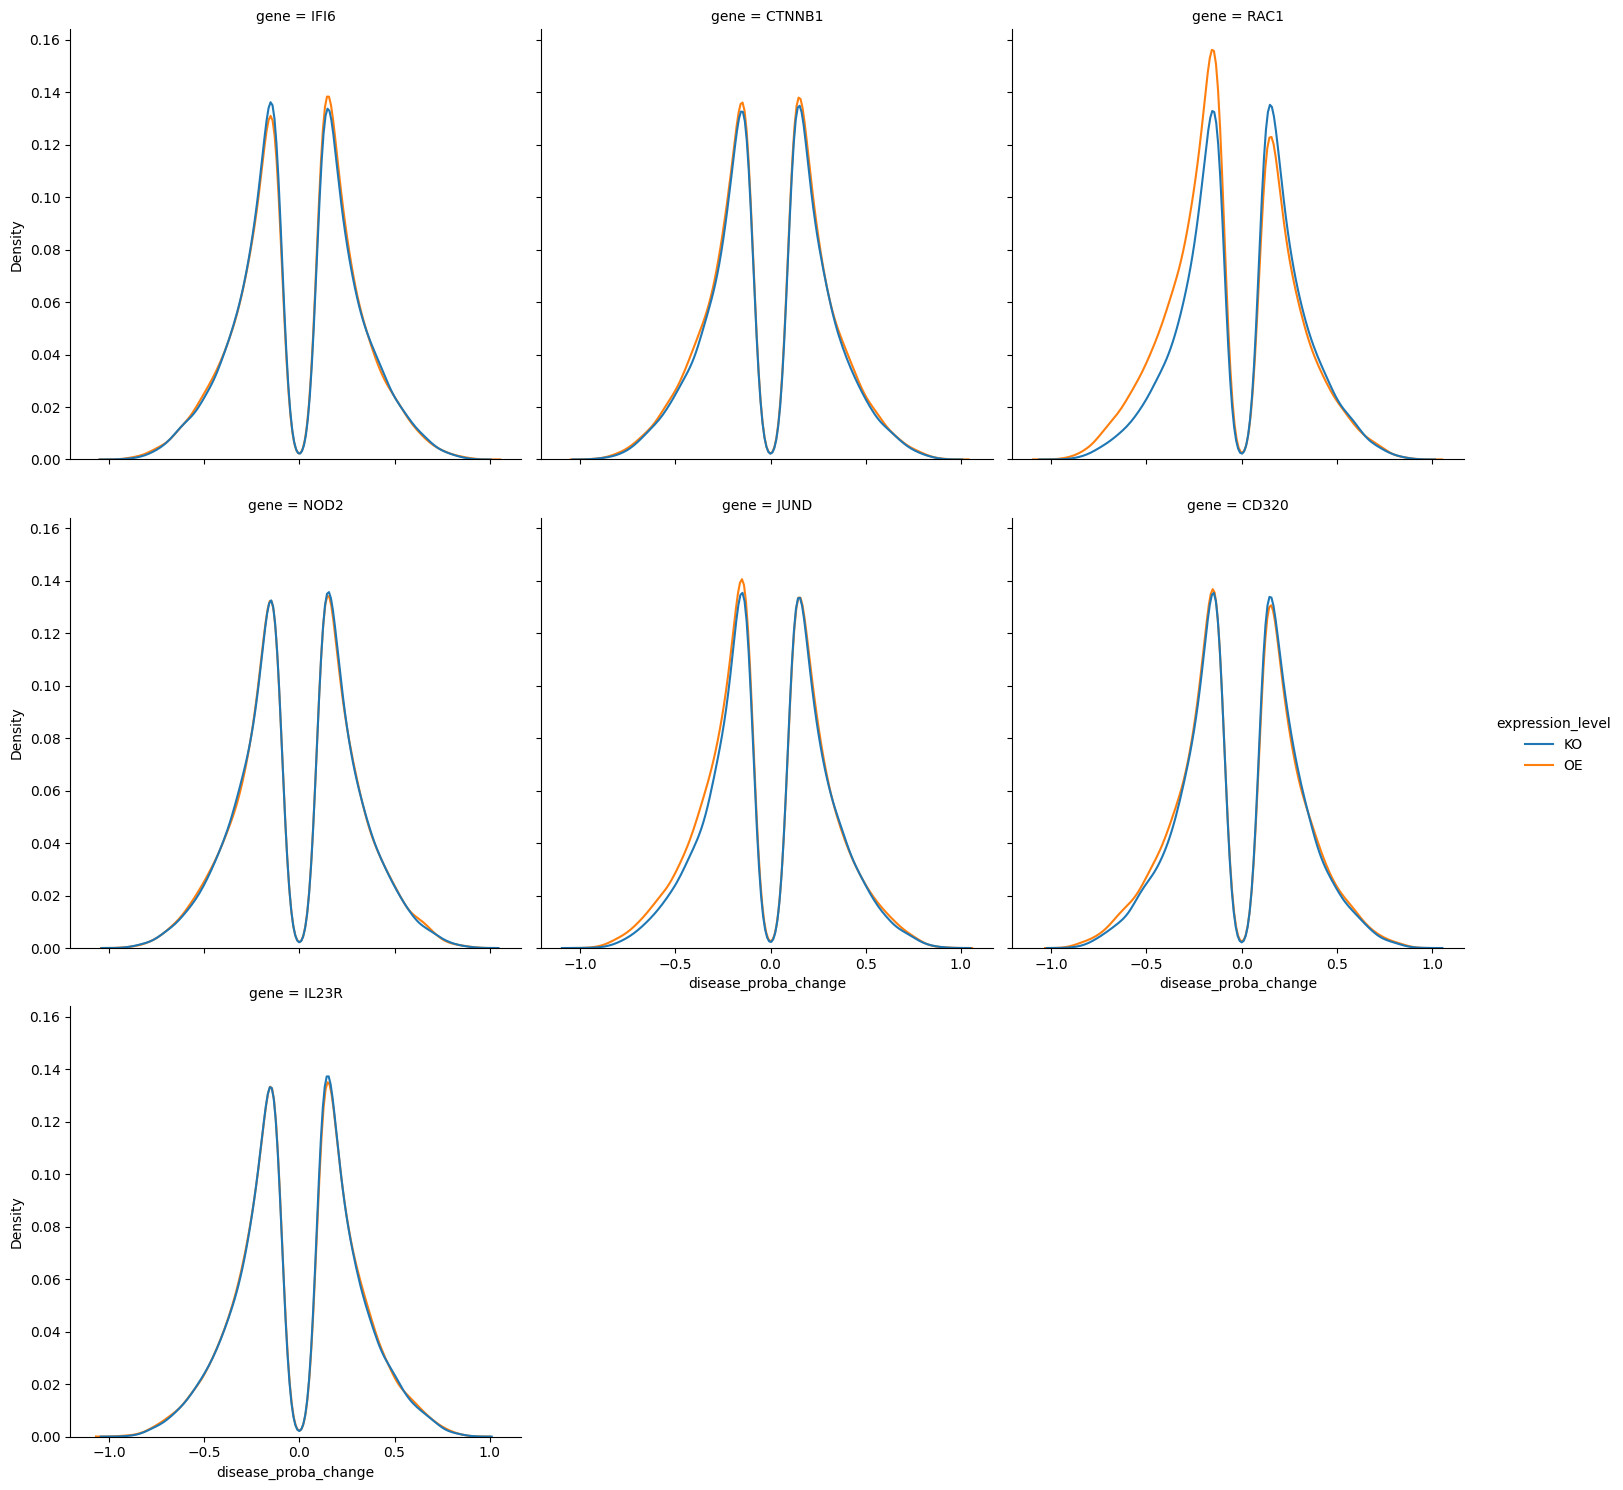

In [49]:
sns.displot(
    data=df.query("abs(disease_proba_change) > 0.10"),
    x="disease_proba_change",
    hue="expression_level",
    log_scale=False,
    kind="kde",
    col="gene",
    col_wrap=3,

)


In [50]:
# does different genes, show different effects on the disease probability?

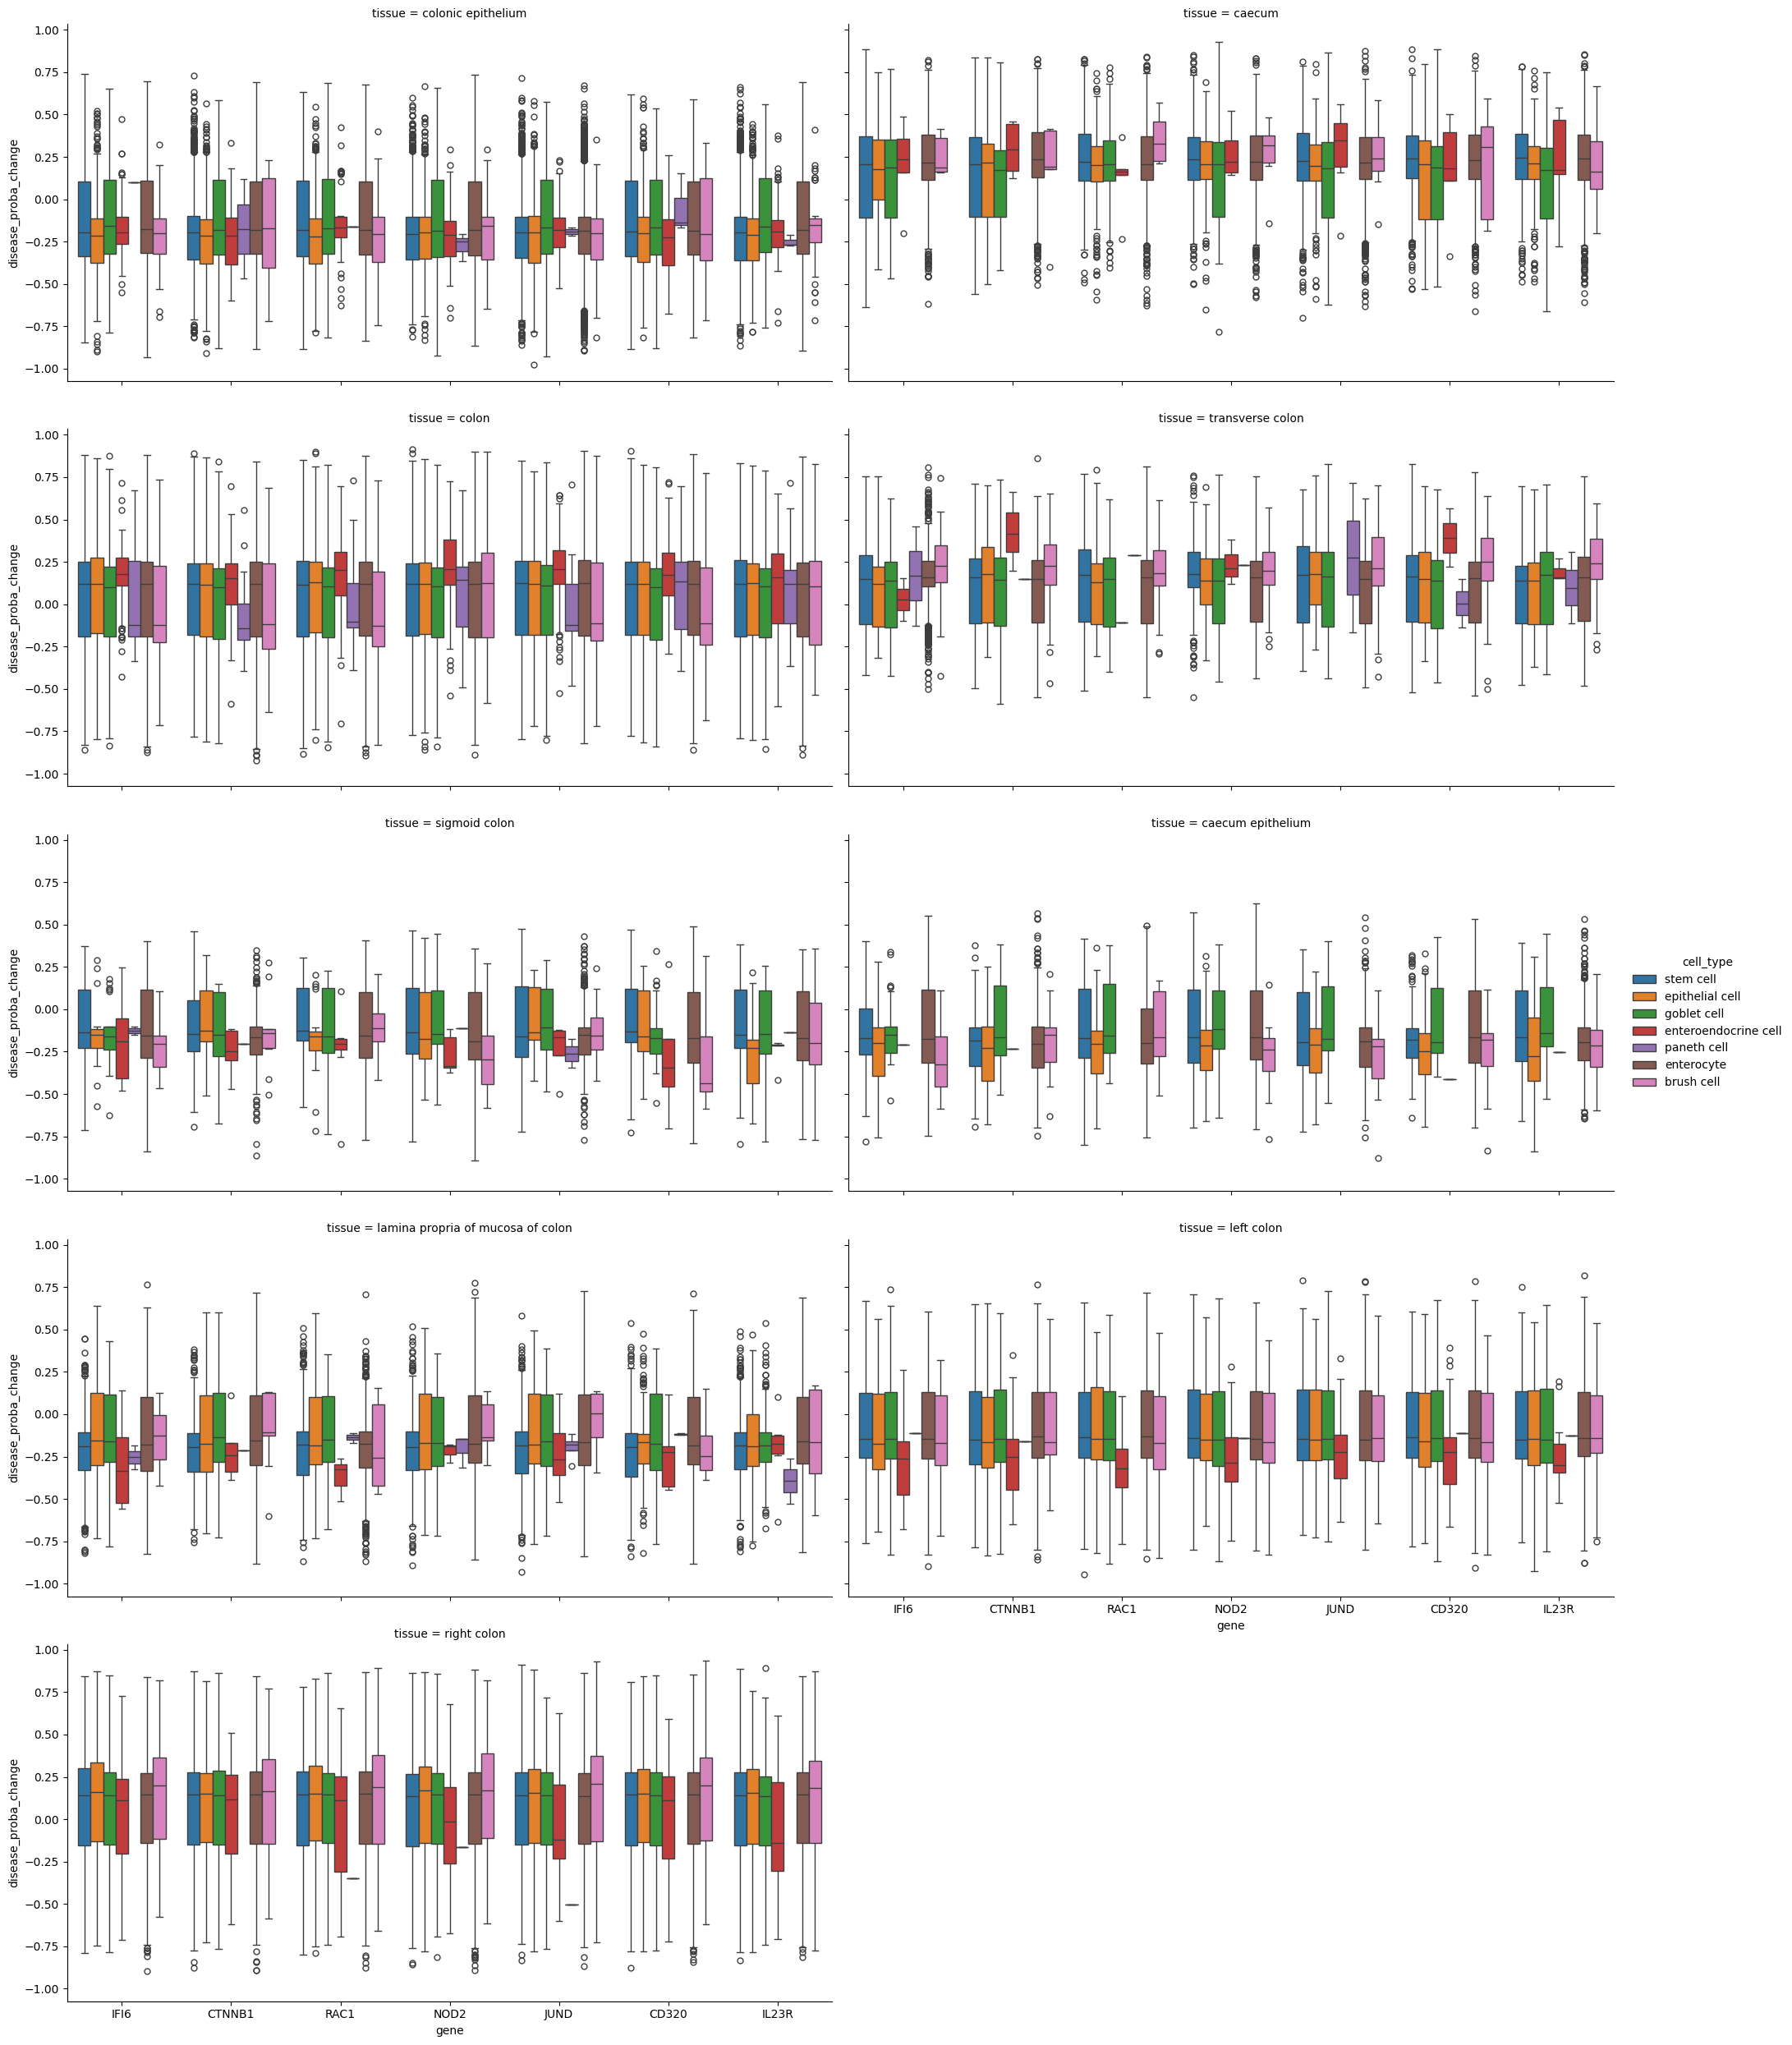

In [68]:
change_cutoff = 0.1
pertubation_level = "KO"
changed_prob_cells = df.query(f"abs(disease_proba_change) > {change_cutoff}").query(
    f"expression_level == '{pertubation_level}'"
)
sns.catplot(
    data=changed_prob_cells,
    x="gene",
    y="disease_proba_change",
    hue="cell_type",
    kind="box",
    aspect=2,
    col="tissue",
    col_wrap=2,
)


In [76]:
df.query("abs(disease_proba_change) > 0.1").groupby(["gene", "expression_level"])[
    ["disease_proba_change"]
].std().sort_values("disease_proba_change", ascending=False)


,,disease_proba_change
gene,expression_level,
RAC1,OE,0.316401
JUND,OE,0.313283
CD320,OE,0.311573
CTNNB1,OE,0.307018
IFI6,OE,0.304876
NOD2,OE,0.304788
IL23R,OE,0.304295
JUND,KO,0.304029
CTNNB1,KO,0.303585


In [78]:
gene = "RAC1"
gb = ["tissue","cell_type"]
df.query(f"gene == '{gene}'")

,tissue,cell_type,disease,disease_probability_base,gene,expression_level,disease_probability,disease_proba_change
cell_id,,,,,,,,
N105446_L-ATTGTTCCAAACGTGG,lamina propria of mucosa of colon,paneth cell,Crohn disease,0.996019,RAC1,KO,0.998636,0.002617
N105446_L-TCGACGGGTGAGACCA,lamina propria of mucosa of colon,paneth cell,Crohn disease,0.999010,RAC1,KO,0.999218,0.000208
N105446_L-AGTAACCGTTAAGGGC,lamina propria of mucosa of colon,paneth cell,Crohn disease,0.996615,RAC1,KO,0.998853,0.002239
N105446_L-GCAGGCTTCGCTAAAC,lamina propria of mucosa of colon,goblet cell,Crohn disease,0.999778,RAC1,KO,0.999347,-0.000431
N105446_L-ATCTTCATCTGAGAGG,lamina propria of mucosa of colon,goblet cell,Crohn disease,0.996219,RAC1,KO,0.997278,0.001059
...,...,...,...,...,...,...,...,...
N130084_L-GTGGTTACAGTTCCAA,lamina propria of mucosa of colon,brush cell,Crohn disease,0.991700,RAC1,OE,0.947301,-0.044399
N130084_L-TATCCTATCGTTCATT,lamina propria of mucosa of colon,enterocyte,Crohn disease,0.989881,RAC1,OE,0.962722,-0.027159
N130084_L-TCATCCGGTATGATCC,lamina propria of mucosa of colon,enterocyte,Crohn disease,0.998500,RAC1,OE,0.907608,-0.090892
